# Character Classification on Characters Extracted from Generated Title Pages

In [1]:
import matplotlib.pyplot
import numpy
import os
import PIL.Image
import scipy.ndimage
import tensorflow

In [2]:
# border padding used when the region of interest is first placed into a square image; caused
# a bit of confusion since this is how it is described in the EMNIST paper, but my
# interpretation of this description isn't displayed in the image from the EMNIST paper shown
# above
BORDER_PADDING = 2

# maximum pixel value used in the grayscale images; 0.0=black, 255.0=white
MAX_PIXEL_VALUE = 255.0

# dimensions of the EMNIST data and the target dimensions for the printed data so both data
# sources are in the same format
TARGET_IMAGE_DIMS = (28, 28)

TARGET_IMAGE_DIMS_WITHOUT_PADDING = tuple(
    dim - (2 * BORDER_PADDING) for dim in TARGET_IMAGE_DIMS
)

In [3]:
"""
Helper function that transforms images into a target size, following a certain process along
the way.

Args:
    image_files (list): list of full paths of images to transform

Returns:
    A numpy.ndarray of the transformed images.
"""
def transform_data(image_files):

    # will store numpy.ndarrays containing the transformed version of each image represented
    # by a full path in the input list; will be converted to a numpy.array itself and returned
    transformed_data = []

    for full_image_path in image_files:

        # the transformation process utilizes different libraries including PIL.Image,
        # scipy.ndimage, and numpy to be as fast as possible

        # load the image using PIL.Image
        pixel_array = PIL.Image.open(full_image_path)

        # convert to a numpy.ndarray for the next step in the transformation process
        cols, rows = pixel_array.size
        pixel_matrix = numpy.array(pixel_array, dtype=numpy.float64).reshape((rows, cols))

        # apply a Gaussian filter to the image with sigma=1 to soften the edges, using
        # scipy.ndimage
        pixel_matrix = scipy.ndimage.gaussian_filter(pixel_matrix, sigma=1)

        # convert back to a PIL.Image object for the next step in the transformation
        # process
        pixel_array = PIL.Image.fromarray(pixel_matrix)

        # downsample the image to the target dimensions (minus the padding) using bi-cubic
        # interpolation
        pixel_array = pixel_array.resize(
            TARGET_IMAGE_DIMS_WITHOUT_PADDING,
             resample=PIL.Image.BICUBIC,
        )

        # convert back to a numpy.ndarray for the next step in the transformation process
        cols, rows = pixel_array.size
        pixel_matrix = numpy.array(pixel_array, dtype=numpy.float64).reshape((rows, cols))

        # add a whitespace border to the image (keeping it square)
        rows, cols = pixel_matrix.shape
        row_padding = numpy.zeros((BORDER_PADDING, cols))
        pixel_matrix = numpy.concatenate(
            (row_padding, pixel_matrix, row_padding),
            axis=0,
        )
        col_padding = numpy.zeros((rows + (2 * BORDER_PADDING), BORDER_PADDING))
        pixel_matrix = numpy.concatenate(
            (col_padding, pixel_matrix, col_padding),
            axis=1,
        )

        # the downsampling step in the transformation process can potentially increase pixel
        # values over the maximum pixel value, this step reduces these pixel values back down
        # to the maximum pixel value; this step also scales the pixel values down to a range
        # of [0, 1] for ease of use in the model
        _reduce_pixel_values_over_max_and_scale = numpy.vectorize(
            lambda pixel_value: min(pixel_value / MAX_PIXEL_VALUE, 1.0)
        )
        pixel_matrix = _reduce_pixel_values_over_max_and_scale(pixel_matrix)

        transformed_data.append(pixel_matrix)

    transformed_data = numpy.array(transformed_data)

    return transformed_data

In [4]:
"""
Helper function that displays an image that's internally represented as a numpy.ndarray.

Args:
    pixel_matrix (numpy.ndarray): image to display
"""
def show_image(pixel_matrix):
    matplotlib.pyplot.figure()
    matplotlib.pyplot.imshow(pixel_matrix)
    matplotlib.pyplot.colorbar()
    matplotlib.pyplot.grid(False)
    matplotlib.pyplot.show()

In [5]:
ENGLISH_ALPHABET = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"

EXPECTED_X_CHARACTERS = "UGOFOSCOLO.ABONAPARTE.DEDI.CADELL'ODA"
EXPECTED_Y_CHARACTERS = "FOSCOLOUGODELL'ODADEDI.CA.BONAPARTE.A"

In [34]:
"""
Args:
    model (tensorflow.keras.Sequential): model to use to classify character images
    images_dir (string): directory containing all characters extracted from a page
    expected_chars (string): the true labels of the extracted characters to calculate accuracy
    out_file (string): full path to output file that will contain classifications by line
"""
def make_classifications(model, images_dir, expected_chars, out_file):
    ordered_images_by_line = {}
    for image_file in (f for f in os.listdir(images_dir) if f.endswith(".jpg")):
        line_num, _, img_num, _ = image_file.split("_")
        if int(line_num) not in ordered_images_by_line:
            ordered_images_by_line[int(line_num)] = []
        ordered_images_by_line[int(line_num)].append(
            (int(img_num), os.path.join(images_dir, image_file))
        )

    line_numbers, image_files = [], []
    for line_num in sorted(ordered_images_by_line.keys()):
        for _, image_file in sorted(ordered_images_by_line[line_num], key=lambda t: t[0]):
            line_numbers.append(line_num)
            image_files.append(image_file)

    transformed_images = transform_data(image_files)
    predictions = model.predict(transformed_images)
    hard_predictions = []
    correct = 0
    for i in range(len(image_files)):
        show_image(transformed_images[i])
        prediction = ENGLISH_ALPHABET[numpy.argmax(predictions[i])]
        print("Actual character: {}".format(expected_chars[i]))
        print("Hard prediction: {}".format(prediction))
        labels_shown = 0
        actual_label_shown = False
        for label, prob in sorted(enumerate(predictions[i]), key=lambda t: -t[1]):
            if expected_chars[i] not in ENGLISH_ALPHABET:
                actual_label_shown = True
            if ENGLISH_ALPHABET[label] == expected_chars[i]:
                actual_label_shown = True
            print(ENGLISH_ALPHABET[label], prob)
            labels_shown += 1
            if labels_shown >=4 and actual_label_shown:
                break
        hard_predictions.append(prediction)
        if prediction == expected_chars[i]:
            correct += 1
    print("")
    print("Accuracy on English alphabet characters: {:.2f}%".format(
        (correct / len([char for char in expected_chars if char in ENGLISH_ALPHABET])) * 100
    ))

    current_line_num = 0
    with open(out_file, "w") as f:
        for i, hard_prediction in enumerate(hard_predictions):
            line_num = line_numbers[i]
            if line_num != current_line_num:
                if expected_chars[i] in ENGLISH_ALPHABET:
                    f.write("\n")
                current_line_num = line_num
            if expected_chars[i] in ENGLISH_ALPHABET:
                f.write(hard_prediction)

In [7]:
model = tensorflow.keras.models.load_model("./Data/pretrained_model.hdf5")

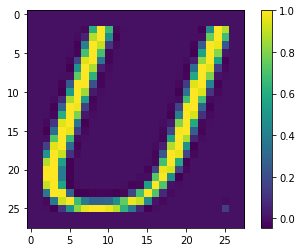

Actual character: U
Hard prediction: U
U 0.8343523
W 0.1495788
O 0.010809746
Y 0.002292964


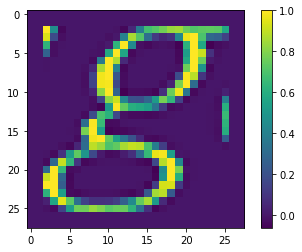

Actual character: G
Hard prediction: G
G 0.9997613
S 0.00019311577
Z 3.4487875e-05
E 6.322717e-06


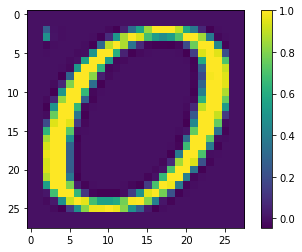

Actual character: O
Hard prediction: O
O 0.9993144
G 0.00024455888
C 0.00019718139
N 7.061185e-05


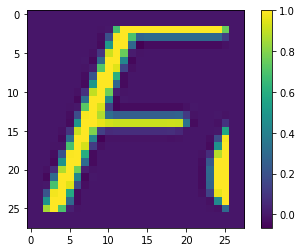

Actual character: F
Hard prediction: F
F 0.96952313
K 0.011270683
A 0.008526955
E 0.0054409695


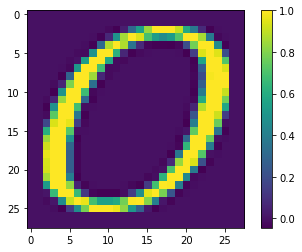

Actual character: O
Hard prediction: O
O 0.99943584
G 0.00017689633
C 0.00017314397
A 6.0774088e-05


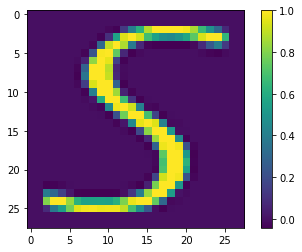

Actual character: S
Hard prediction: S
S 0.9999666
G 3.3254124e-05
J 6.41515e-08
F 7.735399e-09


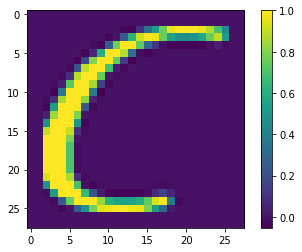

Actual character: C
Hard prediction: C
C 0.90081614
G 0.09864798
E 0.00023786478
A 0.00020700469


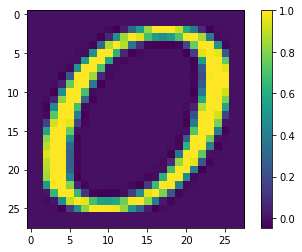

Actual character: O
Hard prediction: O
O 0.9994235
G 0.00017831607
C 0.00017765239
A 6.249164e-05


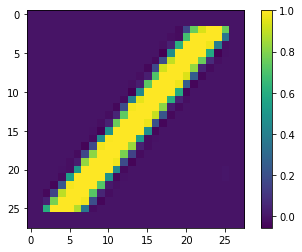

Actual character: L
Hard prediction: L
L 0.8041355
I 0.13296439
Y 0.025487265
H 0.015798392


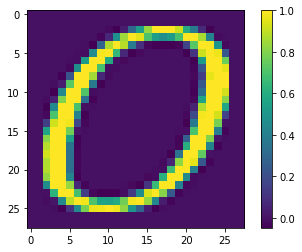

Actual character: O
Hard prediction: O
O 0.99939406
G 0.00019154364
C 0.00018845718
A 6.5230066e-05


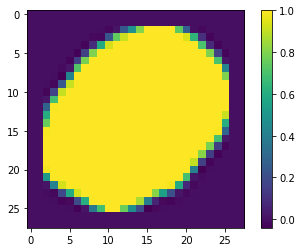

Actual character: .
Hard prediction: O
O 0.9977794
C 0.00084209593
W 0.0008287021
Q 0.00028155322


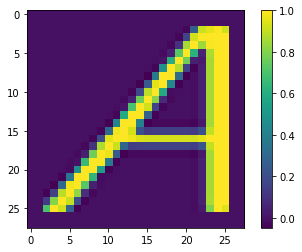

Actual character: A
Hard prediction: A
A 0.99870265
F 0.00030687897
Q 0.0002960489
M 0.0002087313


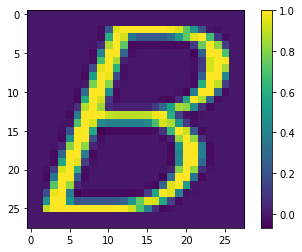

Actual character: B
Hard prediction: B
B 0.99977094
G 0.00015806223
D 2.648462e-05
R 2.1392518e-05


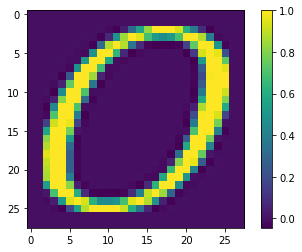

Actual character: O
Hard prediction: O
O 0.9994561
C 0.00017290606
G 0.00016376037
N 6.409965e-05


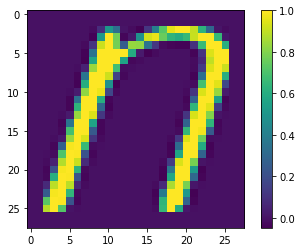

Actual character: N
Hard prediction: N
N 0.9950251
A 0.0036979555
H 0.00062666065
Q 0.00031049567


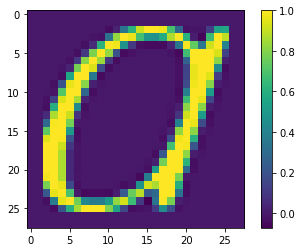

Actual character: A
Hard prediction: O
O 0.88380194
G 0.08097431
A 0.032256454
C 0.0016749314


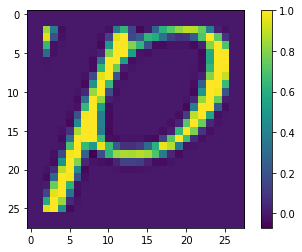

Actual character: P
Hard prediction: P
P 0.98310685
N 0.008866904
R 0.0055222656
Q 0.0023771


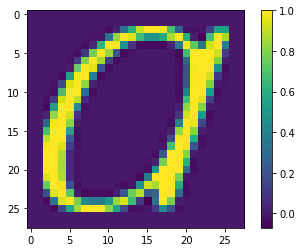

Actual character: A
Hard prediction: O
O 0.8886707
G 0.075983874
A 0.03243339
C 0.0016352887


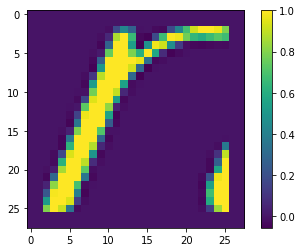

Actual character: R
Hard prediction: R
R 0.8246466
K 0.13754825
A 0.016132344
M 0.0059069903


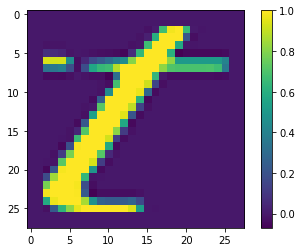

Actual character: T
Hard prediction: T
T 0.9834901
Z 0.011903975
Y 0.0013665975
G 0.0008244664


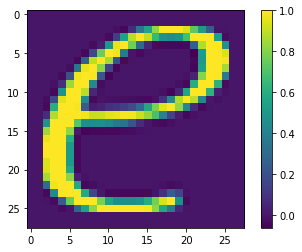

Actual character: E
Hard prediction: E
E 0.971677
G 0.014044078
C 0.011875152
Q 0.0023638248


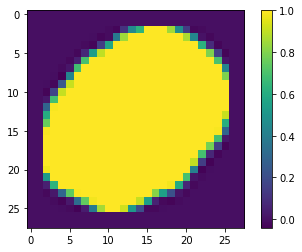

Actual character: .
Hard prediction: O
O 0.9967649
W 0.0015763057
C 0.0011274512
Q 0.00017345995


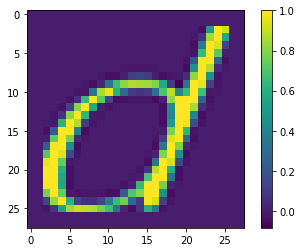

Actual character: D
Hard prediction: D
D 0.9935819
A 0.00282865
U 0.0020653931
O 0.0007451839


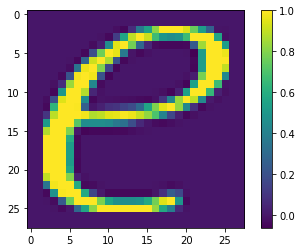

Actual character: E
Hard prediction: E
E 0.9711572
G 0.013514889
C 0.012815986
Q 0.0024698547


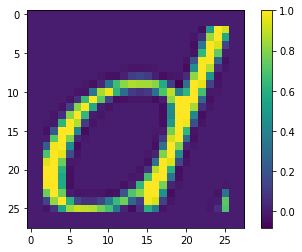

Actual character: D
Hard prediction: D
D 0.99167013
A 0.0040610745
U 0.0028074416
O 0.00064258196


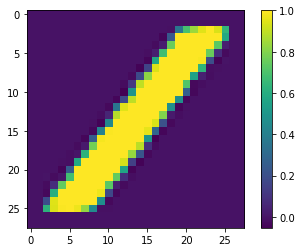

Actual character: I
Hard prediction: L
L 0.81399566
I 0.13371983
H 0.029224755
F 0.0039911033


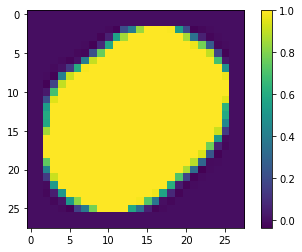

Actual character: .
Hard prediction: O
O 0.99782515
W 0.0010047989
C 0.00094558526
G 7.66334e-05


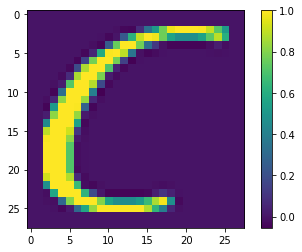

Actual character: C
Hard prediction: C
C 0.90939593
G 0.08995038
E 0.0002907631
A 0.00026191113


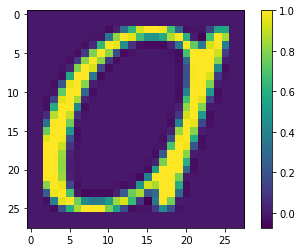

Actual character: A
Hard prediction: O
O 0.88330966
G 0.081350766
A 0.03234428
C 0.001686967


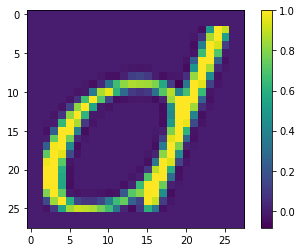

Actual character: D
Hard prediction: D
D 0.99364614
A 0.00287703
U 0.0019862007
O 0.00072560564


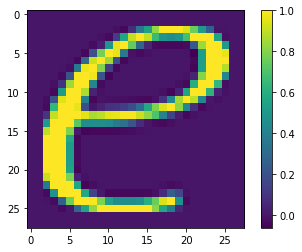

Actual character: E
Hard prediction: E
E 0.97016865
G 0.0145243285
C 0.012846684
Q 0.0024172678


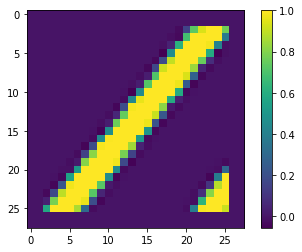

Actual character: L
Hard prediction: L
L 0.99295336
I 0.0041949246
H 0.001236549
D 0.00039794832


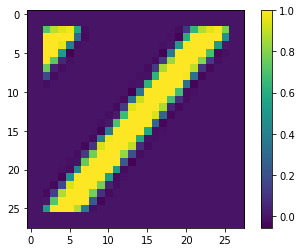

Actual character: L
Hard prediction: T
T 0.65082556
L 0.25377432
Y 0.03641433
H 0.018496346


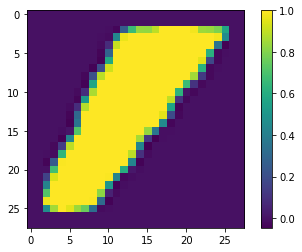

Actual character: '
Hard prediction: R
R 0.61134326
F 0.1441536
V 0.1032205
N 0.059561767


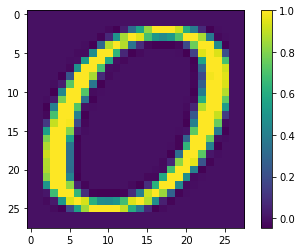

Actual character: O
Hard prediction: O
O 0.9994092
G 0.00019191903
C 0.0001732905
N 7.014026e-05


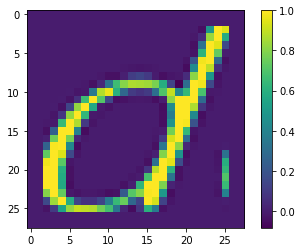

Actual character: D
Hard prediction: D
D 0.981533
A 0.010152992
U 0.0061663166
O 0.0011633015


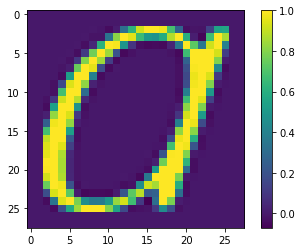

Actual character: A
Hard prediction: O
O 0.88721114
G 0.07759491
A 0.03227383
C 0.0016366147

Accuracy on English alphabet characters: 81.82%


In [35]:
make_classifications(
    model,
    "./Data/demo/extracted_characters/x/",
    EXPECTED_X_CHARACTERS,
    "./Data/demo/predicted_letters/x.txt",
)

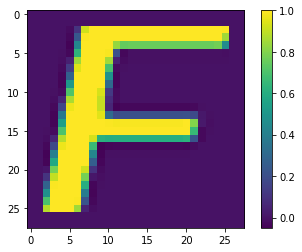

Actual character: F
Hard prediction: F
F 0.9999559
E 3.1673524e-05
G 8.181034e-06
R 3.815613e-06


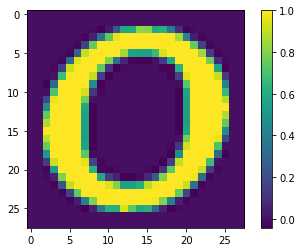

Actual character: O
Hard prediction: O
O 0.99998057
C 7.278992e-06
Q 4.456154e-06
D 2.449096e-06


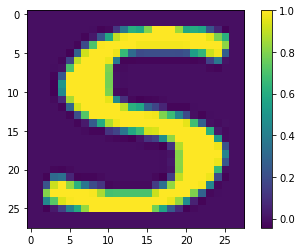

Actual character: S
Hard prediction: S
S 0.9999993
G 7.190925e-07
J 1.4231909e-10
F 5.2829536e-11


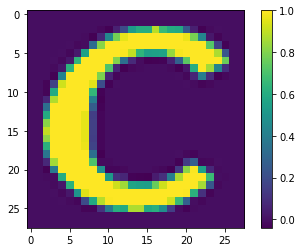

Actual character: C
Hard prediction: C
C 0.99999726
G 2.4776805e-06
E 1.8225043e-07
R 2.7377443e-08


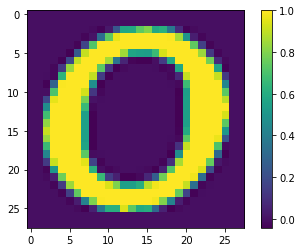

Actual character: O
Hard prediction: O
O 0.9999831
C 6.135419e-06
Q 3.824723e-06
D 2.0786647e-06


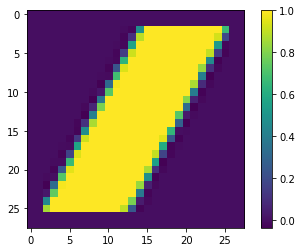

Actual character: L
Hard prediction: L
L 0.6932215
D 0.078857794
I 0.061550304
G 0.035246454


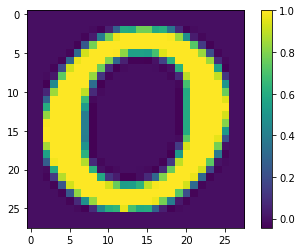

Actual character: O
Hard prediction: O
O 0.99997807
C 8.1281e-06
Q 4.2591346e-06
A 3.657495e-06


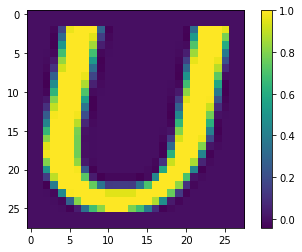

Actual character: U
Hard prediction: U
U 0.99992156
W 7.0765615e-05
V 4.1172857e-06
O 2.4102874e-06


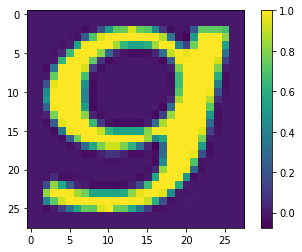

Actual character: G
Hard prediction: G
G 0.9977265
Y 0.0022475054
S 9.752309e-06
J 8.034273e-06


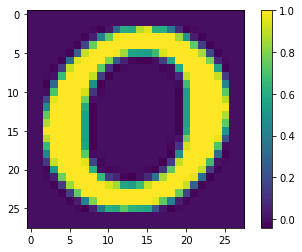

Actual character: O
Hard prediction: O
O 0.9999789
C 6.8943673e-06
Q 5.756319e-06
D 2.9523296e-06


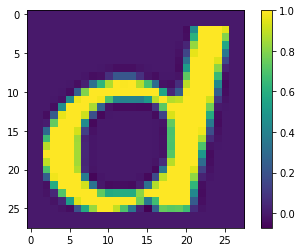

Actual character: D
Hard prediction: D
D 0.9893607
A 0.007697958
O 0.002450505
U 0.00030505244


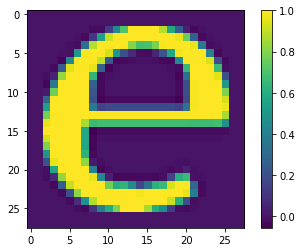

Actual character: E
Hard prediction: E
E 0.98449993
C 0.011163135
Q 0.0035265896
A 0.00055869756


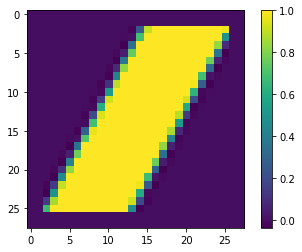

Actual character: L
Hard prediction: L
L 0.5897332
I 0.14345933
D 0.09529381
G 0.027954446


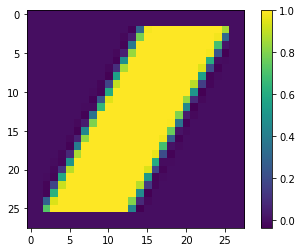

Actual character: L
Hard prediction: L
L 0.6628874
I 0.10152846
D 0.08007253
G 0.027315134


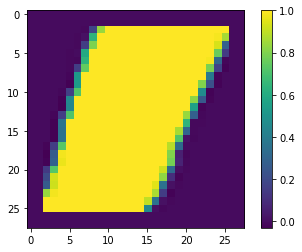

Actual character: '
Hard prediction: D
D 0.18056022
G 0.16983841
W 0.13937764
V 0.120901555


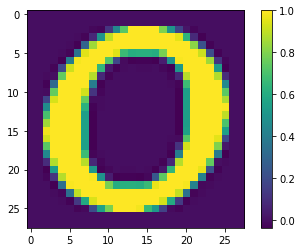

Actual character: O
Hard prediction: O
O 0.99997735
C 8.223012e-06
Q 4.903086e-06
D 4.81592e-06


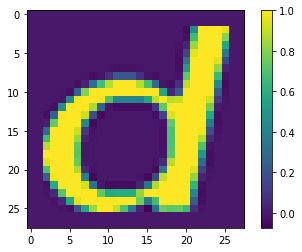

Actual character: D
Hard prediction: D
D 0.9890788
A 0.007621845
O 0.0027805453
U 0.0003064308


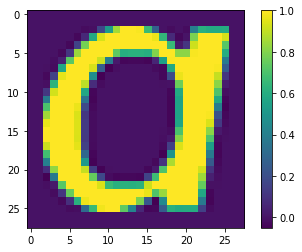

Actual character: A
Hard prediction: A
A 0.58179206
G 0.3231567
O 0.08375219
C 0.005794509


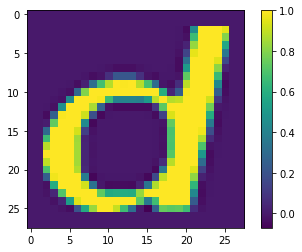

Actual character: D
Hard prediction: D
D 0.9891962
A 0.007900204
O 0.0024095199
U 0.0003044066


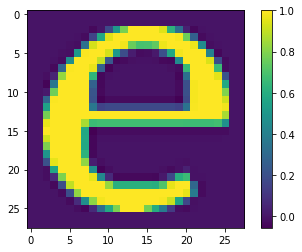

Actual character: E
Hard prediction: E
E 0.98629075
C 0.009645257
Q 0.0034065878
A 0.00041930727


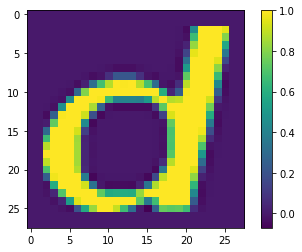

Actual character: D
Hard prediction: D
D 0.9891962
A 0.007900204
O 0.0024095199
U 0.0003044066


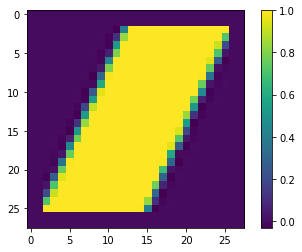

Actual character: I
Hard prediction: D
D 0.33790913
B 0.13266566
N 0.110512294
V 0.065846324
L 0.060369175
A 0.045661617
R 0.0377879
M 0.03722759
G 0.033965275
I 0.031393293


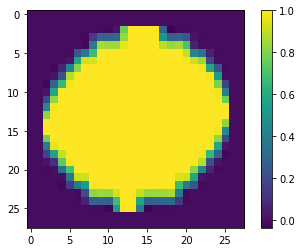

Actual character: .
Hard prediction: O
O 0.99437237
Q 0.002653038
W 0.002311385
C 0.00026653096


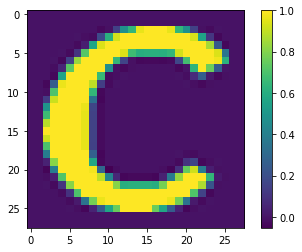

Actual character: C
Hard prediction: C
C 0.99999905
G 8.4628596e-07
E 1.2574205e-07
R 1.1943106e-08


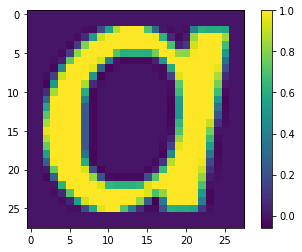

Actual character: A
Hard prediction: A
A 0.49904072
G 0.37623355
O 0.110218056
Q 0.0067770155


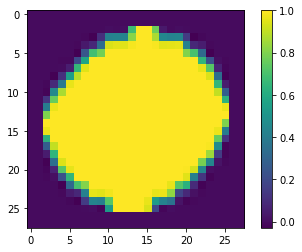

Actual character: .
Hard prediction: O
O 0.9983541
W 0.00062219275
Q 0.0003883318
C 0.00028312212


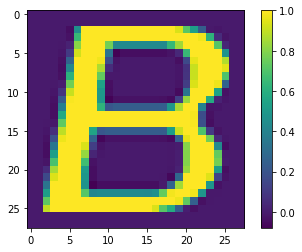

Actual character: B
Hard prediction: B
B 0.9999207
D 3.7062076e-05
G 2.4519115e-05
S 1.2031239e-05


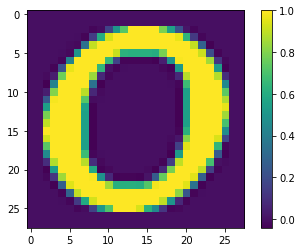

Actual character: O
Hard prediction: O
O 0.99997365
C 8.465935e-06
Q 6.657414e-06
D 6.0031775e-06


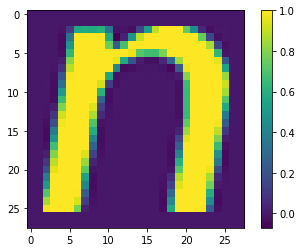

Actual character: N
Hard prediction: N
N 0.9999633
A 1.3973165e-05
W 7.0800393e-06
D 4.9688283e-06


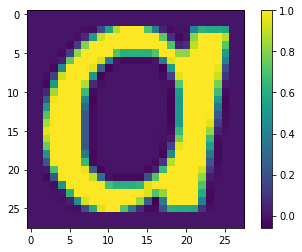

Actual character: A
Hard prediction: A
A 0.49010754
G 0.34591538
O 0.1467002
C 0.008450812


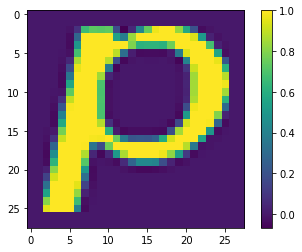

Actual character: P
Hard prediction: P
P 0.9994906
N 0.00039322162
R 0.00010293695
F 5.549297e-06


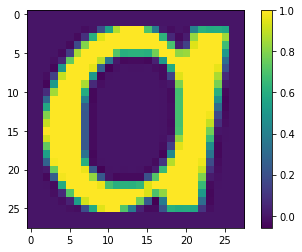

Actual character: A
Hard prediction: A
A 0.5018785
G 0.39346713
O 0.09174388
C 0.006743614


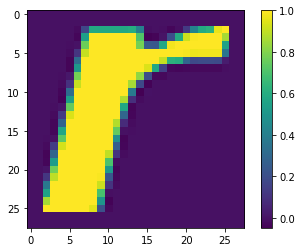

Actual character: R
Hard prediction: R
R 0.99917585
F 0.00057194545
N 0.000117576266
G 5.463098e-05


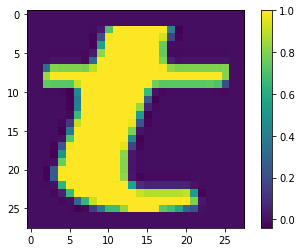

Actual character: T
Hard prediction: T
T 0.9397338
C 0.05850452
E 0.0015076316
K 0.00014589456


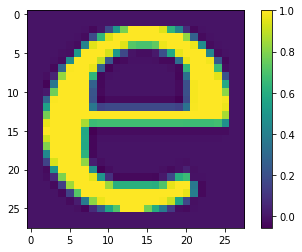

Actual character: E
Hard prediction: E
E 0.9865398
C 0.009024879
Q 0.0038471257
A 0.00037096758


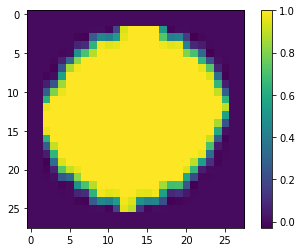

Actual character: .
Hard prediction: O
O 0.98844296
Q 0.007950739
W 0.0029281485
C 0.0003804307


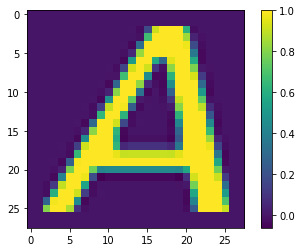

Actual character: A
Hard prediction: A
A 0.9913073
H 0.0031778559
Q 0.0024045776
K 0.0010746771

Accuracy on English alphabet characters: 96.97%


In [36]:
make_classifications(
    model,
    "./Data/demo/extracted_characters/y/",
    EXPECTED_X_CHARACTERS,
    "./Data/demo/predicted_letters/y.txt",
)